# Section 1: Relational Data Model Design & Implementation

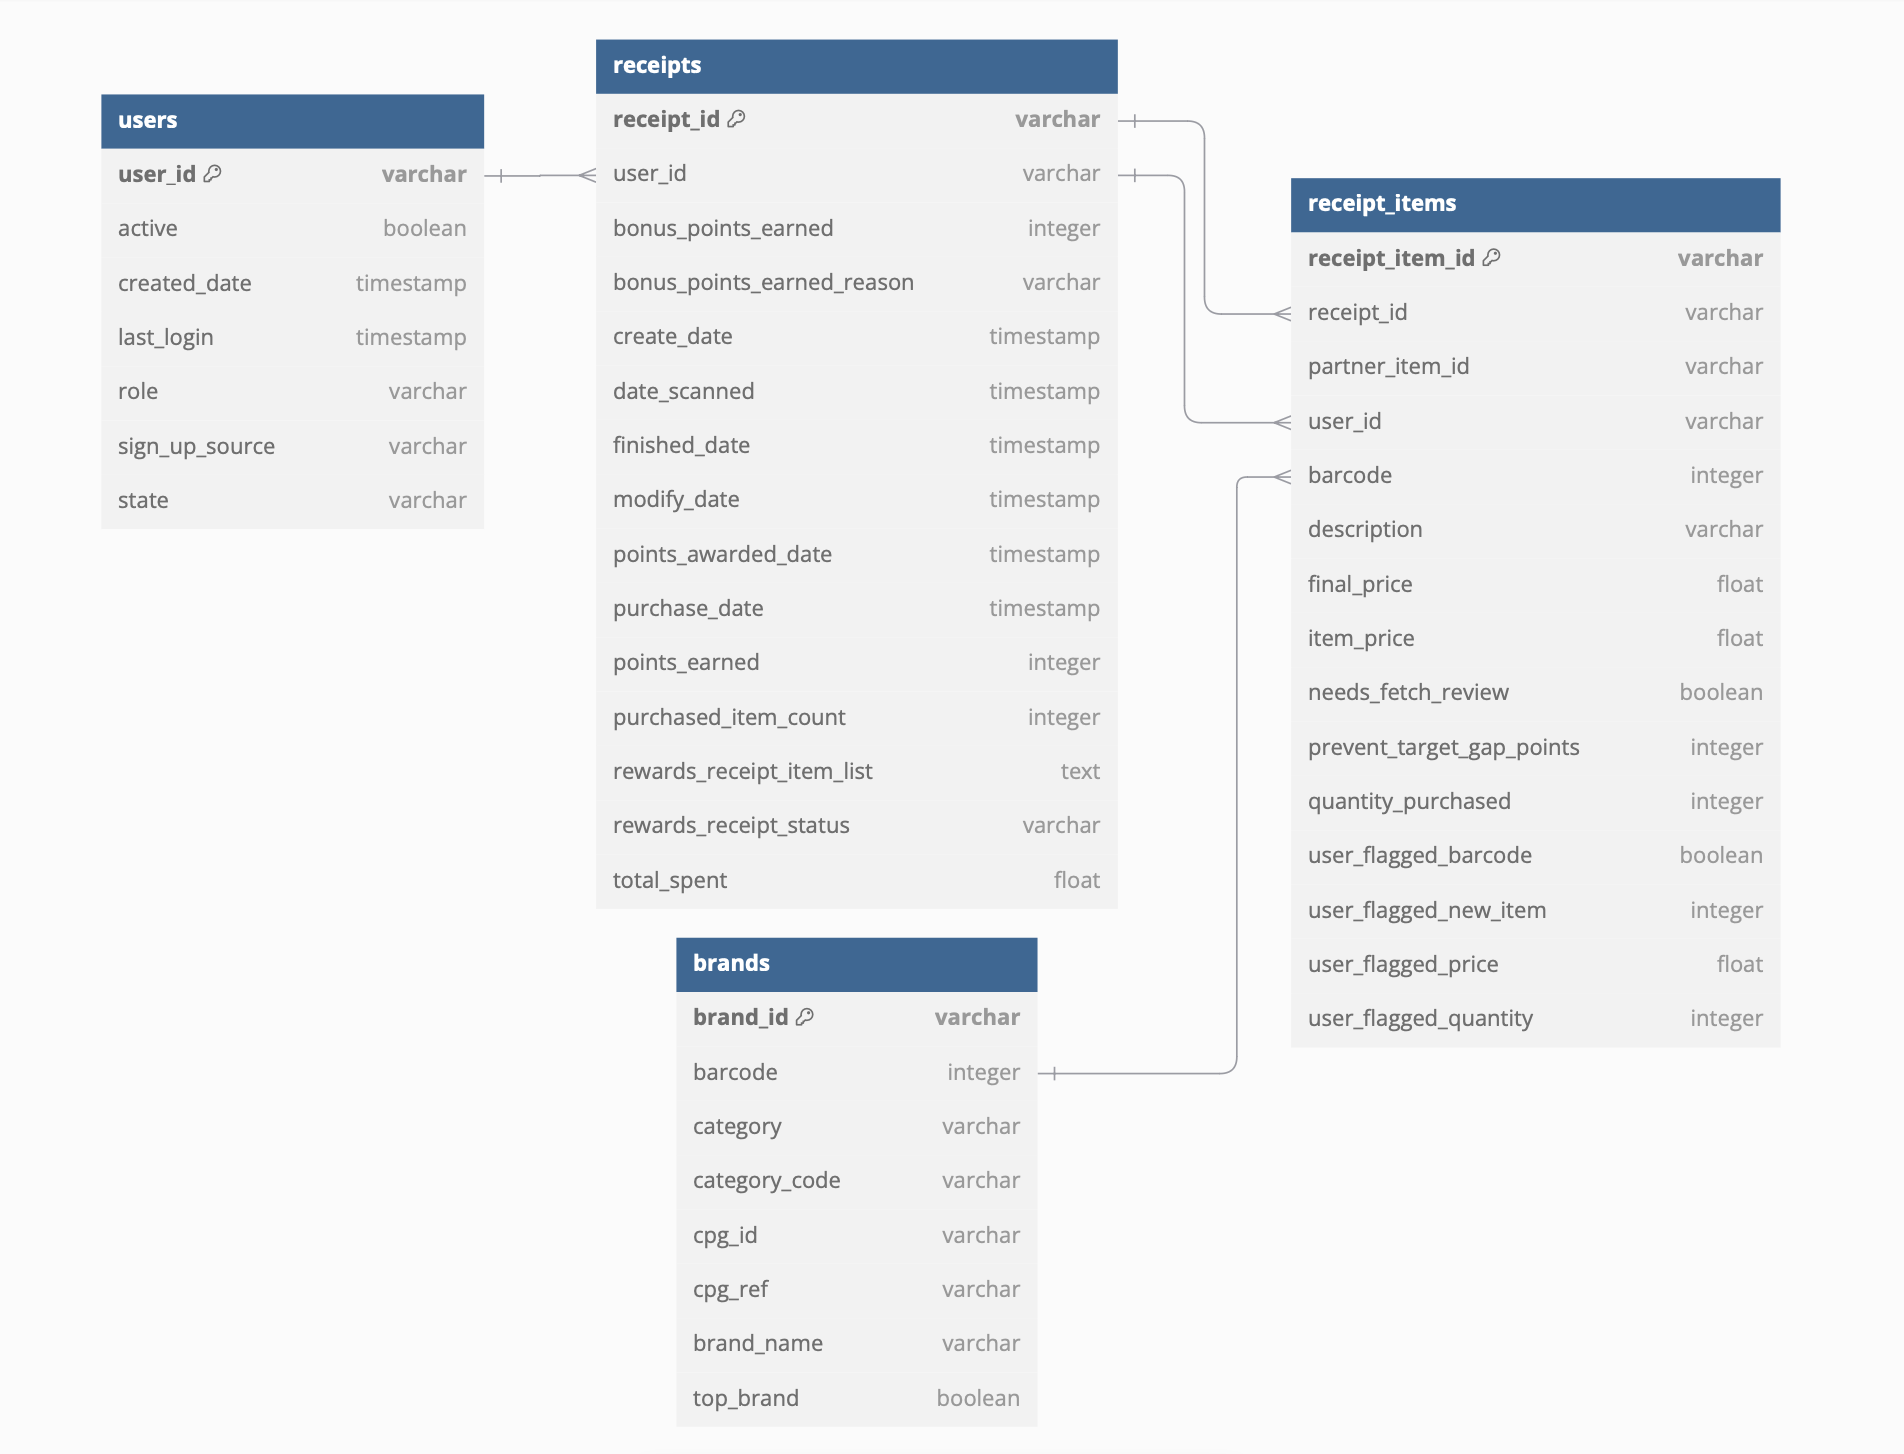

In [2]:
from IPython.display import display
from PIL import Image

display(Image.open("images/er_diagram.png"))

# Section 2: Business Question Answering

## Receipt Analysis

### When considering average spend from receipts with 'rewardsReceiptStatus’ of ‘Accepted’ or ‘Rejected’, which is greater?

**Answer:** Receipts with `rewards_receipt_status = 'FINISHED'` have higher average spend compared to those where `rewards_receipt_status = 'REJECTED'`

### When considering total number of items purchased from receipts with 'rewardsReceiptStatus’ of ‘Accepted’ or ‘Rejected’, which is greater?
**Answer:** There are more total items purchased among receipts with `rewards_receipt_status = 'FINISHED'` compared to those where `rewards_receipt_status = 'REJECTED'`

## Brand Analysis

### Which brand has the most spend among users who were created within the past 6 months?
**Answer:** Among the matched brands, Cracker Barrel Cheese is the brand with the most speend among users created within the past 6 months. However, Miller Lite seems to be the actual brand with the most spend among users when we account for unmatched brands.

### Which brand has the most transactions among users who were created within the past 6 months?
**Answer:** Among the matched brands, Tostitos is the brand with the most transactions among users created within the past 6 months. However, Klarbrunn seems to be the actual brand with the most transactions among users when we account for unmatched brands.

# Section 3: Data Quality Investigation

## DQ Investigation: users table

Potential DQ issues:

* Duplicated `user_id`,
* null `last_login`, `sign_up_source`, `state`
* skewed `state` to be mainly Wisconsin
* skewed user distribution to 2021 January, no users in 2018-2019
* no cases where last login in between 1 and 119 days since user creation date

## DQ Investigation: Receipts table

Potential DQ issues:
* no points earned despite showing `rewards_receipt_status = 'FINISHED'`
* points distribution strongly concentrated around two small ranges
* PENDING receipts don't have records of items purchased or points earned
* SUBMITTED receipts don't have records of total spent, items purchased, or points earned

## DQ Investigation: Brands Table

Potential DQ issues:

* some categories don't map to their category codes 
* brands with null `category` & `category_code`
* many cases of `brand_name` having "test brand" prefix
* brands with null `top_brand`
* barcode only starts with `51111`

## DQ Investigation: Receipt Items Table

Potential DQ issues:

* much wider space of barcodes, which means many items won't be joinable to the brands table
    * more of a `brands` table issue
* multiple cases of `needs_fetch_review` being null when 0 and 1 are observed values
* multiple cases `user_flagged_barcode`, `user_flagged_new_item`, and `user_flagged_quantity` being null
    * may not be an issue since it seems to rely on users actively flagging a field

# Section 4: Stakeholder Communication


To make it a bit more realistic, I'll set Jasper Seldin (Ranking & Relevance PM) as the recipient of this email.

Hi Jasper,

Hope this email finds you well.

I've been looking through some of our core tables (*receipts*, *users*, and *brands*) and using them to answer some business questions.

In the process, I found some potential data quality issues that limited my confidence in presenting the findings to stakeholders.

You can find the details in section 3 of [`responses.ipynb`](link), but the most striking ones include:

- **[users]** `user_id` is non-unique
- **[users]** Most users were created in January 2021 and are from Wisconsin
- **[receipts]** Strongly bimodal distribution of points awarded in the receipts table
- **[brands]** Brands table only has barcodes that begin with `51111`
- **[receipt items]** Most barcodes in the receipts items table don't begin with `51111`

I found these potential issues by first identifying the most intuitively important columns, then looking at missing data rates, distribution of non-null fields, and column-level relationships with other tables.

The main question I have is whether these issues are expected or not – if not, here are some follow-up questions that would better help me address the issues:
- Has anyone on the integrations team recently flagged an integration issue porting data from S3 to Snowflake?
- What should the distribution of bonus points awarded look like? Are there cases 
- Are there states that we don't operate in? What are some of the most important states in terms of revenue?

Additionally, I heard about the ML workflows you and the company have in mind, and I'd love to support that effort by optimizing the data transformation processes in these tables.

To that end, I have the following questions:

- How often does your team (and the business) query these tables?
- Do you (or the business) anticipate having to generate multiple complex queries downstream of these tables?
- How important is it that the data is up to date?  Or can you tolerate the latest data being delayed by a few hours for your use case? What about a day?

This is on the more AE side of things, but your answers here will allow me to better understand whether to materialize these data assets as views, incrementals, or tables and determine the optimal cadence of full-refreshing these tables as they get much larger.

As we scale, we anticipate longer data update runtimes as table dependencies become more complex, big/slow tables begin blocking parallelizable downstream tasks, and technical debt limits meaningful refactors to speed up runtime.

To address these, we'll do the following to further improve the business' experience with data as we continue to scale:

- Standardize and optimize the way we assign materializations to tables
- Run tables at predictable cadences via Airflow in parallel where permissible so you and the business can get access to the latest data at consistent times throughout the day
- Run a set of essential tests daily to ensure historical metrics remain the same and streamed data remain reasonable throughout the day
- Set aside time to clean up dependencies and refactor the "monster queries" that make up some of our tables

Happy to set up a time to meet and discuss further. Thanks!


Best,

Aaron
